<a href="https://colab.research.google.com/github/premonish/YOUNGER_deprecated/blob/main/YOUNGER_Age_Estimator_PREPROCESS_MODEL_050221_1203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **YOUNGER - Age Estimator**

# **IV. PREPROCESSING**

## **4.1 Contents**
* 4.1 Contents
* 4.2 Introduction
* 4.3 Imports
* 4.4 Load Data
* 4.5 Transform Data
* 4.6 Train/Test Split
* 4.7 Data Augmentation
* 4.8 Transfer Learning
* 4.9 Summary
* 4.10 References


---



##**4.2 Introduction**

Previously, to create an age-predictor, we have completed a notebook import data and explore its attributes: [Data Wrangling & Exploratory Data Analysis](https://github.com/premonish/YOUNGER/blob/main/notebooks/YOUNGER_Age_Estimator_WRANGLING_EDA_v2.ipynb). We took a close look at the metadata and plotted some histograms of the variable distributions. We transformed the data to extract the age of the primary face in each image from their date-of-birth and the date the photo was taken. We focused on extracting a long array of vectors of the pixel information per photo. We finished the previous phase by creating 2 arrays: 'matrix_x' with each row containing the (150,000+ pixel/image) data from each image in the dataset, and 'vector_y' containing the corresponding 'age' labels for the images. 

In this notebook, we will focus on Preprocessing & Modeling. In particular, we will use a Convolutional Neural Network, which is industry standard for Machine Learning image classification tasks due to its unmatched performance.  


---



**Historical Context** 
>
> Image classification has been around for decades, however the field has been rapidly maturing in the last decade.  Since 2010, [ImageNet](https://https://en.wikipedia.org/wiki/ImageNet) Large Scale Visual Recognition Challenge (ILSVRC) is an annual competition where teams attempt to categorize thousands of images into 1,000 classes. In 2012, 'AlexNet' won the competition by a landslide and this is considered a pivotal moment in the history of deep learning, enabled by ingenious data scientists, a massive labeled dataset, and GPUs for training.




**PREPROCESSING** will be focused on three main sections.

1. Create Dummy Variables for categorical variables where appropriate.
2. Standardize the magnitude of numeric features using a scaler.
3. Split data into testing and training datasets.

**MODELING** will focus on the following four phases.
1. Train the models on the dataset (fit)
2. Review model performance metrics
3. Iterate over other models
4. Identify the final model  


---



## **4.3 Imports**

In [1]:
# !pip install tensorflow

In [2]:
# Create a list of currently installed python libraries for posterity
# !pip freeze > requirements.txt

In [3]:
### IMPORT libraries and packages ###
### I get by with a little help from my friends ###
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# deep-learning imports

from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential
from keras import metrics
from keras.models import model_from_json

# import PIL
# from PIL import Image
# import seaborn as sns
# from pathlib import Path
# import random
# import requests
# import scipy.io
# from keras.preprocessing import image
# from keras.applications.resnet import preprocess_input
# from datetime import datetime, date, time, timedelta

In [4]:
# mount GDrive where the dataset is stored for Colab environment
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **4.4 Load Data**
Let's load the compressed numpy arrays from disk, extract data, and check the number of rows in our dataset.

In [5]:
%%time
from numpy import asarray, savez_compressed, load
# load dict of arrays
images = np.load('/content/drive/MyDrive/YOUNGER/data3.npz', allow_pickle=True)
matrix_x = images.f.arr_0
matrix_x.shape

CPU times: user 14 s, sys: 1.85 s, total: 15.9 s
Wall time: 18.5 s


In [6]:
# load the ages array 'vector_y'
ages = np.load('/content/drive/MyDrive/YOUNGER/data4.npz', allow_pickle=True)
vector_y = ages.f.arr_0
vector_y.shape

(4623,)

In [7]:
# check output matrix_x & vector_y shapes
# both matrix_x and vector_y are arrays of the same length 
assert vector_y.shape == matrix_x.shape

In [8]:
# subset data
X0 = matrix_x
# X1 = matrix_x[5000:6000]
# X2 = matrix_x[10000:12000]
# X3 = matrix_x[15000:20000]
# X4 = matrix_x[20000:]

X = matrix_x
y = vector_y
# X = matrix_x[:5000]
# y = vector_y[:5000]

### NOTE: I'm running some tests to see how many images to include without overwhelming Google Colab's Ram. 
### I have already upgraded to Colab Pro for this project and have been reaching the RAM limits

# y = vector_y[:6000]
# convert to tensor
# [tf.convert_to_tensor(a) for a in X]
# [tf.convert_to_tensor(a) for a in y];

(array([670., 402., 469., 402., 469., 402., 469., 402., 469., 469.]),
 array([14. , 20.5, 27. , 33.5, 40. , 46.5, 53. , 59.5, 66. , 72.5, 79. ]),
 <a list of 10 Patch objects>)

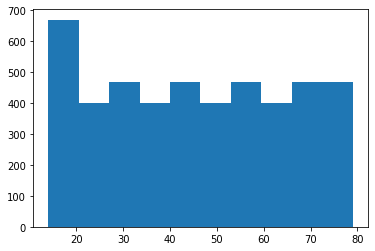

In [9]:
plt.hist(y)

---
# **TEST**
---
I will write a function to resample the classes equally so that I have 1% from each class. I will eliminate the 0 class so that I have exactly 100 classes and each class represents 1%.

In [10]:
# df_target = pd.DataFrame(y)
# df_1 = df_target[df_target == 10] 

# list1 = []
# list2 = []
# for i in range(1,101):
#   #  print(i, df_target[df_target == i].count())
#    list1.append(i)
#    list2.append(df_target[df_target == i].count())
# # df_1.count()
# list3 = list(zip(list1, list2))
# plt.bar(list1, list2)

---
# **TEST**
---

In [11]:
#SHOW DISTRIBUTION OF THE CLASSES AS PERCENTAGE#

## **4.5 Transform Data**

**One-Hot Encoding**

We need to encode the 'ages' label as categorical (binary) representations to prevent a hierarchical interpretation. 
The Keras API provides a 'to_categorical()' method that can be used to one-hot encode integer data. 

In [12]:
# classes = 64 # ages 0 to 100
# classes = 64 # ages 14 to 79
target = y
target_classes = keras.utils.to_categorical(target) # "Converts a class vector (integers) to binary class matrix." 

**Reshaping the Data**

We must reshape the data into the standard input array shape of a 'rank 4 tensor' to prepare for the Tensorflow CNN.

(b, w, h, c) : (batch, width, height, channels)

In [13]:
features = []
for i in range(0, len(X)):
    features.append(X0[i])
features = np.array(features)
features = features.reshape(len(X),224,224,3)
features.shape

(4623, 224, 224, 3)

In [14]:
#### TEST ###$#$#$
### NOTE: I'm running some tests to see how many images to include without overwhelming Google Colab's Ram. 
### I have already upgraded to Colab Pro for this project and have been reaching the RAM limits
# %%time
# features = []
# # for i in range(0, len(X0)):
# #     features.append(X0[i])
# # for i in range(0, len(X1)):
# #     features.append(X1[i])
# # for i in range(0, len(X2)):
# #     features.append(X2[i])
# # for i in range(0, len(X3)):
# #     features.append(X3[i])
# features = np.array(features)

**Scale the Data**

Each of the pixel values range from 0-255. Let's scale the values to from 0-1 by dividing each value by 255. Interestingly, we are actually performing this operation virtually instantly 150,528 times per image (times the number of images).

In [15]:
features /= 255        # scale down pixel values to range [0, 1]
print("The maximum value in our dataset is:", features.max())

The maximum value in our dataset is: 1.0


## **4.6 Train/Test Split**
We will divide the dataset randomly into training data and test data (80/20). We will later perform data augmentation on only the training set to help balance the classes of ages in the dataset.

In [16]:
# train/ test split
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(features, target_classes, test_size=0.20, random_state=42 , stratify=target_classes)

In [17]:
print("X_train shape =",train_x.shape,"| X_test shape =",test_x.shape)
print("y_train shape =",train_y.shape,"| y_test shape =",test_y.shape)

X_train shape = (3698, 224, 224, 3) | X_test shape = (925, 224, 224, 3)
y_train shape = (3698, 80) | y_test shape = (925, 80)


## **4.7 Data Augmentation**
Balance the classes by upsampling the underrepresented classes. ImageDataGenerator creates transformed images to expand the training segment of the dataset.

In [18]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.2, # Randomly zoom image 
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip = True,  # randomly flip images
#         vertical_flip=False)  # randomly flip images

# # datagen.fit(train_x)


In [19]:
# import os
# from datetime import datetime
# now = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
# dir_name = 'img' + now
# os.makedirs(dir_name)
# for X_batch, y_batch in datagen.flow(train_x, train_x, batch_size=9, save_to_dir=dir_name, save_prefix='aug', save_format='png'):
# 	for i in range(0, 9):
# 		plt.subplot(330 + 1 + i)
# 		plt.imshow(X_batch[i].reshape(224,224,3), cmap=plt.get_cmap('gray'))
# 	plt.show()
# 	break

In [20]:
# bgen = BalancedDataGenerator(features, target, datagen, batch_size=32)

In [21]:
# steps_per_epoch = bgen.steps_per_epoch

---
---
---
#**TEST**

In [22]:
# from keras.utils.data_utils import Sequence
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.keras import balanced_batch_generator

# class BalancedDataGenerator(Sequence):
#     """ImageDataGenerator + RandomOversampling"""
#     def __init__(self, x, y, datagen, batch_size=32):
#         self.datagen = datagen
#         self.batch_size = min(batch_size, x.shape[0])
#         datagen.fit(x)
#         self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
#         self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
#     def __len__(self):
#         return self.steps_per_epoch

#     def __getitem__(self, idx):
#         x_batch, y_batch = self.gen.__next__()
#         x_batch = x_batch.reshape(-1, *self._shape[1:])
#         return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

In [23]:
# bgen = BalancedDataGenerator(train_x[:2000], train_y[:2000], datagen, batch_size=32)
# steps_per_epoch = bgen.steps_per_epoch

#**TEST**
---
---
---

## **4.8 CNN Architecture**

I'll start by testing an established effective architecture (VGG-Face model) for this task along with trained weights. ***[UPDATE REQUIRED: INCLUDE CITATION & DETAILS]***.
https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf

In [24]:
#VGG-Face model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

## **4.9 Transfer Learning**

Load trained weights. ***[UPDATE REQUIRED: INCLUDE CITATION & DETAILS]***.
https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf

In [25]:
model.load_weights('/content/drive/MyDrive/YOUNGER/vgg_face_weights.h5')

In [26]:
# freeze layers to use transfer learning effectively
for layer in model.layers[:-7]:
  layer.trainable = False
 
base_model_output = Sequential()
base_model_output = Convolution2D(80, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)
 
age_model = Model(inputs=model.input, outputs=base_model_output)

In [27]:
#check trainable layers
if False:
    for layer in model.layers:
        print(layer, layer.trainable)
    
    print("------------------------")
    for layer in age_model.layers:
        print(layer, layer.trainable)

In [28]:
# Stochastic Gradient Descent = sgd
# compile the model
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=.9, nesterov=True)

age_model.compile(loss='categorical_crossentropy'
                  , optimizer=keras.optimizers.Adam()
                  #, optimizer = sgd
                  , metrics=['accuracy']
                 )

In [29]:
# create checkpoint which saves the best model based on loss on the validation data
checkpointer = ModelCheckpoint(
    # filepath='/content/classification_age_model.hdf5'
    filepath='/content/drive/MyDrive/YOUNGER/classification_age_model2.hdf5'
    , monitor = "val_loss"
    , verbose=1
    , save_best_only=True
    , mode = 'min'
    # , mode = 'auto'
)

In [30]:
# set batch size and # of epochs
# fit the model on training set & validate on the test set
scores = []

enableFit = False

if enableFit:
    # epochs = 250 # original
    # batch_size = 256 # original
    epochs = 320
    batch_size = 32

    for i in range(epochs):
        print("epoch ",i)
        
        ix_train = np.random.choice(train_x.shape[0], size=batch_size)
        
        score = age_model.fit(
            train_x[ix_train], train_y[ix_train]
            , epochs=1
            , validation_data=(test_x, test_y)
            , callbacks=[checkpointer]
        )
    # datagen.fit(train_x)
        # score = age_model.fit_generator(bgen, steps_per_epoch, epochs=1
        #     ,validation_data=(test_x[:2000], test_y[:2000]), callbacks=[checkpointer])
    # score = age_model.fit(datagen.flow(train_x, train_y, batch_size=32),
    #       steps_per_epoch=len(train_x) / 32, epochs=epochs
    #         , validation_data=(test_x, test_y)
    #         , callbacks=[checkpointer])
        
    scores.append(score)
    
    #restore the best weights
    from keras.models import load_model
    # age_model = load_model('/content/classification_age_model.hdf5')
    age_model = load_model('/content/drive/MyDrive/YOUNGER/classification_age_model2.hdf5')
    
    age_model.save_weights('/content/drive/MyDrive/YOUNGER/age_model_weights_3.h5')
        
else:
    #pre-trained weights for age prediction: https://drive.google.com/file/d/1YCox_4kJ-BYeXq27uUbasu--yz28zUMV/view?usp=sharing
    age_model.load_weights("/content/drive/MyDrive/YOUNGER/age_model_weights_3.h5")

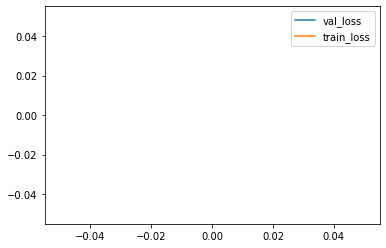

In [31]:
# plot training loss vs. validation loss over epochs
val_loss_change = []; loss_change = []
for i in range(0, len(scores)):
    val_loss_change.append(scores[i].history['val_loss'])
    loss_change.append(scores[i].history['loss'])

plt.plot(val_loss_change, label='val_loss')
plt.plot(loss_change, label='train_loss')
plt.legend(loc='upper right')
plt.show()

In [32]:
# loss_change[0][0]

In [33]:
# loss and accuracy on validation set
age_model.evaluate(test_x, test_y, verbose=1)

29/29 [==============================] - 24s 144ms/step - loss: 3.6028 - accuracy: 0.0866


[3.617323160171509, 0.07999999821186066]

In [34]:
predictions = age_model.predict(test_x)

In [35]:
output_indexes = np.array([i for i in range(0, 80)])
apparent_predictions = np.sum(predictions * output_indexes, axis = 1)

In [36]:
mae = 0
for i in range(0 ,apparent_predictions.shape[0]):
    prediction = int(apparent_predictions[i])
    actual = np.argmax(test_y[i])
    # prediction - actual #create a list
    # plt.plot(actual, predicted)
    abs_error = abs(prediction - actual)
    mae = (mae + abs_error) / apparent_predictions.shape[0]

print("mae: ",mae)
print("instances: ",apparent_predictions.shape[0])

mae:  0.004326663079562882
instances:  925


In [37]:
def loadImage(filepath):
    test_img = image.load_img(filepath, target_size=(224, 224))
    test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis = 0)
    test_img /= 255
    return test_img

In [38]:
from keras.preprocessing import image
def image_age(photo):
  prediction = age_model.predict(loadImage(photo))
  img = image.load_img(photo)#, target_size=(224, 224))
  plt.imshow(img)
  plt.show()

  print("Predicted Age: ", np.argmax(prediction))
  apparent_age = np.round(np.sum(prediction * output_indexes, axis = 1))
  # print("Apparent Age: ", int(apparent_age[0]))
  # print("Predicted Age:",((np.argmax(prediction))+ (int(apparent_age[0])))/2)

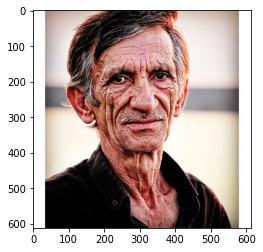

Predicted Age:  73


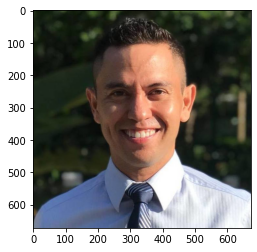

Predicted Age:  38


In [39]:
picture1 = "/content/drive/MyDrive/YOUNGER/face_old.jpeg"
picture2 = "/content/drive/MyDrive/YOUNGER/Baby-Face-Cute.jpg"
picture3 = "/content/drive/MyDrive/YOUNGER/prem_linked.jpg"
# picture4 = ''
image_age(picture1)
# image_age(picture2)
image_age(picture3)
# image_age(picture4)

In [40]:
# y_pos = np.arange(101)
# plt.bar(y_pos, prediction[0], align='center', alpha=0.9)
# plt.ylabel('percentage')
# plt.title('age')
# plt.show()

In [48]:
# create a web image upload & predict sequence
from PIL import Image
import requests

def web_age(url):  
  web_photo = Image.open(requests.get(url, stream=True).raw).save("web_photo.jpg")
  image_age("/content/web_photo.jpg")

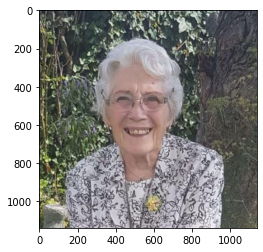

Predicted Age:  64


In [51]:
url = 'https://i.guim.co.uk/img/media/68b70e0ccc658b9b01cc7bf6a972134f2a5136e4/0_186_1900_1139/master/1900.jpg?width=1200&height=1200&quality=85&auto=format&fit=crop&s=c391df10a394dc50fafe584915c753e5'
web_age(url)

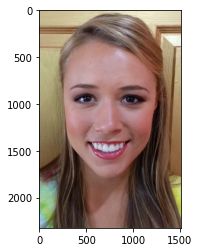

Predicted Age:  16


In [52]:
url = 'https://myimagejourney.com/wp-content/uploads/2013/08/2013-04-20-16.02.40.jpg'
web_age(url)

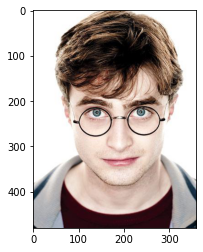

Predicted Age:  22


In [55]:
url = 'https://static.wikia.nocookie.net/harrypotter/images/9/97/Harry_Potter.jpg/revision/latest?cb=20140603201724'
web_age(url)

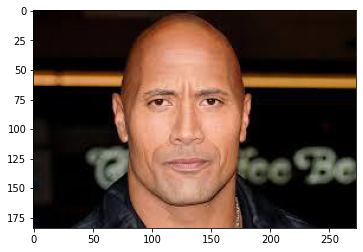

Predicted Age:  51


In [58]:
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRed4B_N95FjRE0a-2sn3OEXAjc0SkMkWeJTQ&usqp=CAU'
web_age(url)



---


# **SUMMARY**


---
##**To be updated...**


# **REFERENCES**


1.   https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ 
2.   https://data.vision.ee.ethz.ch/cvl/publications/papers/proceedings/eth_biwi_01229.pdf
3. https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras/ 
4. https://www.researchgate.net/publication/265125544_Face_Detection_without_Bells_and_Whistles
5. https://github.com/yu4u/age-gender-estimation
6. https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf


---